<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [166]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision.utils as tvutils
import torchvision.transforms.functional as F
import torch
import torch.nn.utils.spectral_norm as spectral_norm
from torch import nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid", font_scale=1.2)

In [102]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [204]:
IMAGE_MEAN = torch.tensor([0.5232, 0.4279, 0.3824])
IMAGE_STD = torch.tensor([0.2497, 0.2237, 0.2208])

In [227]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    # TODO: resize images, convert them to tensors and build dataloader
    transform = tt.Compose(
        [
            tt.Resize(image_size),
            tt.ToTensor(),
            tt.Lambda(lambda x: x * 2 - 1),
            # tt.Normalize(
            #     mean=2 * IMAGE_MEAN - 1,
            #     std=2 * IMAGE_STD,
            # ),
        ]
    )
    dataset = ImageFolder("data/", transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size,
        shuffle=True,
        drop_last=True,
    )
    return dataloader

In [341]:
IMAGE_SIZE = 128
# BATCH_SIZE = 64
BATCH_SIZE = 128
# TODO: build dataloader and transfer it to device
dataloader = get_dataloader(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
dataloader

In [342]:
batch = next(iter(dataloader))[0]
batch[0].min(), batch[0].max()

(tensor(-1.), tensor(0.8431))

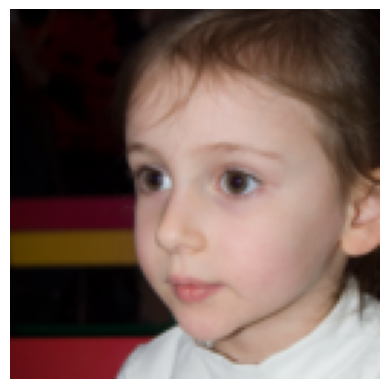

In [346]:
img = batch[0].permute(1, 2, 0)
norm = matplotlib.colors.CenteredNorm(halfrange=1)
plt.imshow(norm(img))
plt.axis("off")
plt.show()

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [347]:
LATENT_DIM = 128

In [432]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.1, inplace=True),
    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1, inplace=True),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
    # nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(0.1, inplace=True),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 1),
    nn.Sigmoid(),
).to(device)

generator = nn.Sequential(
    nn.Linear(LATENT_DIM, 8 * 16 * 16),
    nn.ReLU(inplace=True),
    nn.Unflatten(1, (8, 16, 16)),
    nn.ConvTranspose2d(8, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1),
    nn.Tanh(),
).to(device)

In [433]:
discriminator(batch.to(device)).shape

torch.Size([128, 1])

In [434]:
sample = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
generator(sample).shape

torch.Size([128, 3, 128, 128])

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [331]:
from collections import deque
import random


class BatchBuffer:
    def __init__(self, max_size: int = 5):
        self.buffer = deque(maxlen=max_size)

    def add_and_sample[B](self, batch: B) -> B:
        if len(self.buffer) < self.buffer.maxlen:
            self.buffer.append(batch)
            return batch
        else:
            if random.random() > 0.25:
                idx = random.randint(0, len(self.buffer) - 1)
                old_batch = self.buffer[idx]
                self.buffer[idx] = batch
                return old_batch
            else:
                return batch


buffer = BatchBuffer(max_size=5)

In [302]:
def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, 0.0, 0.02)


initialize_weights(generator)
initialize_weights(discriminator)

In [424]:
def fit(
    generator: nn.Module,
    discriminator: nn.Module,
    epochs: int,
    disc_lr: float,
    gen_lr: float,
    dataloader: DataLoader,
) -> tuple[list[float], list[float]]:
    # criterion = nn.BCELoss()
    criterion = nn.MSELoss()

    disc_optimizer = torch.optim.Adam(
        discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999)
    )
    gen_optimizer = torch.optim.Adam(
        generator.parameters(), lr=gen_lr, betas=(0.5, 0.999)
    )
    # schedule = {"step_size": 5, "gamma": 0.8}
    # gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, **schedule)
    # disc_scheduler = torch.optim.lr_scheduler.StepLR(disc_optimizer, **schedule)

    zeros_batch = torch.zeros(BATCH_SIZE, 1).to(device)
    ones_batch = torch.ones(BATCH_SIZE, 1).to(device) * 0.9  # label smoothing

    disc_losses = []
    gen_losses = []
    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_disc_losses = []
        epoch_gen_losses = []
        for real_batch, _ in tqdm(dataloader, desc="Batches", leave=False):
            # Discriminator step
            real_batch = real_batch.to(device)
            noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
            fake_batch = generator(noise)
            # fake_batch = buffer.add_and_sample(fake_batch.detach())

            disc_optimizer.zero_grad()
            # if epoch % 2 == 0:  # discriminator only trains every other epoch
            disc_real_pred = discriminator(real_batch)
            disc_fake_pred = discriminator(fake_batch.detach())

            disc_real_loss = criterion(disc_real_pred, ones_batch)
            disc_fake_loss = criterion(disc_fake_pred, zeros_batch)
            disc_loss = (disc_real_loss + disc_fake_loss) / 2

            disc_real_accuracy = (disc_real_pred > 0.5).float().mean().item()
            disc_fake_accuracy = (disc_fake_pred < 0.5).float().mean().item()

            disc_loss.backward()
            disc_optimizer.step()

            # Generator step
            disc_fake_pred = discriminator(fake_batch)

            gen_loss = criterion(disc_fake_pred, ones_batch)
            gen_accuracy = (disc_fake_pred > 0.5).float().mean().item()

            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            epoch_disc_losses.append(disc_loss.item())
            epoch_gen_losses.append(gen_loss.item())

            # gen_scheduler.step()
            # if epoch % 2 != 0:
            #     disc_scheduler.step()

        disc_loss = np.mean(epoch_disc_losses)
        gen_loss = np.mean(epoch_gen_losses)

        disc_losses.append(disc_loss)
        gen_losses.append(gen_loss)

        print(
            f"Epoch {epoch + 1}/{epochs}\t"
            f"Discriminator loss: {disc_loss:.4f}, Generator loss: {gen_loss:.4f}\n"
            f"Accuracy\tdisc real: {disc_real_accuracy}, disc fake: {disc_fake_accuracy}, gen: {gen_accuracy}"
        )
        with torch.no_grad():
            img_grid_fake = tvutils.make_grid(fake_batch[:4], padding=1, normalize=True)
            plt.imshow(img_grid_fake.permute(1, 2, 0))  # .cpu().numpy())
            plt.axis("off")
            plt.show()

    return disc_losses, gen_losses

Epochs:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/16	Discriminator loss: 0.2176, Generator loss: 0.1419
Accuracy	disc real: 0.9453125, disc fake: 0.015625, gen: 1.0


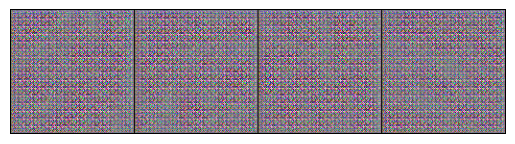

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/16	Discriminator loss: 0.2185, Generator loss: 0.1357
Accuracy	disc real: 1.0, disc fake: 0.0, gen: 1.0


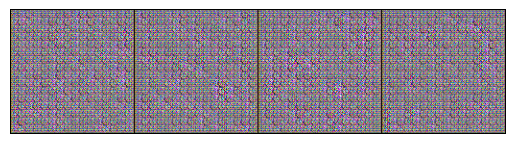

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/16	Discriminator loss: 0.2140, Generator loss: 0.1380
Accuracy	disc real: 1.0, disc fake: 0.0, gen: 1.0


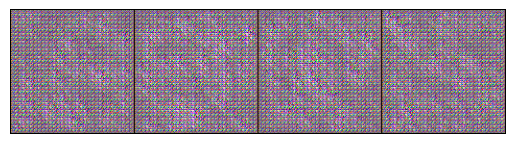

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/16	Discriminator loss: 0.2119, Generator loss: 0.1416
Accuracy	disc real: 1.0, disc fake: 0.0, gen: 1.0


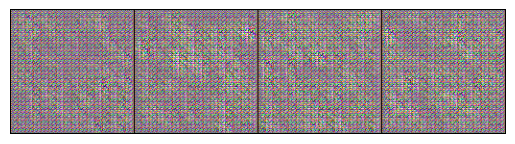

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/16	Discriminator loss: 0.2105, Generator loss: 0.1462
Accuracy	disc real: 0.984375, disc fake: 0.0, gen: 1.0


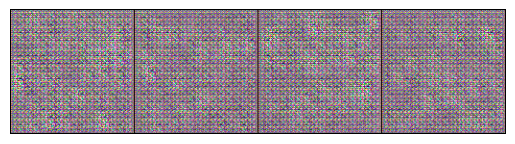

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/16	Discriminator loss: 0.2099, Generator loss: 0.1494
Accuracy	disc real: 0.8828125, disc fake: 0.0, gen: 1.0


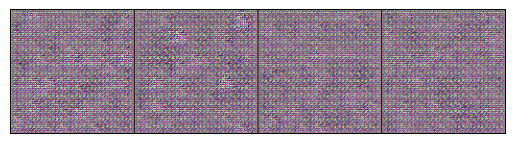

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/16	Discriminator loss: 0.2100, Generator loss: 0.1506
Accuracy	disc real: 0.75, disc fake: 0.0, gen: 1.0


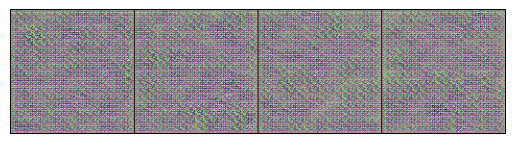

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/16	Discriminator loss: 0.2100, Generator loss: 0.1519
Accuracy	disc real: 0.5390625, disc fake: 0.0, gen: 1.0


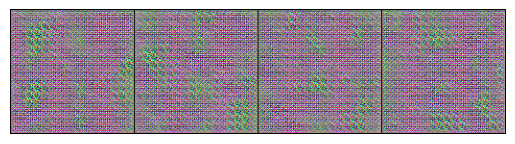

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/16	Discriminator loss: 0.2095, Generator loss: 0.1534
Accuracy	disc real: 0.4921875, disc fake: 0.0078125, gen: 0.9921875


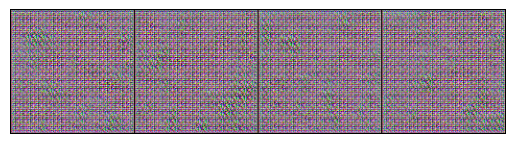

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/16	Discriminator loss: 0.2094, Generator loss: 0.1538
Accuracy	disc real: 0.53125, disc fake: 0.0, gen: 1.0


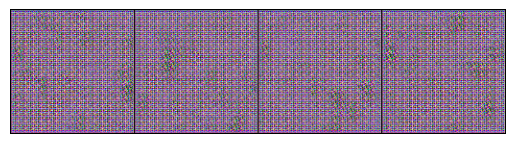

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11/16	Discriminator loss: 0.2090, Generator loss: 0.1544
Accuracy	disc real: 0.390625, disc fake: 0.0, gen: 1.0


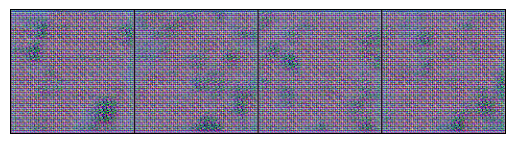

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12/16	Discriminator loss: 0.2088, Generator loss: 0.1552
Accuracy	disc real: 0.3125, disc fake: 0.0, gen: 1.0


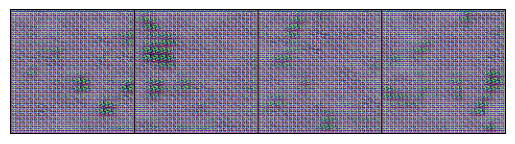

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13/16	Discriminator loss: 0.2088, Generator loss: 0.1554
Accuracy	disc real: 0.2421875, disc fake: 0.0, gen: 0.9921875


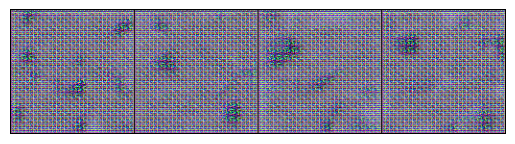

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14/16	Discriminator loss: 0.2082, Generator loss: 0.1566
Accuracy	disc real: 0.1484375, disc fake: 0.0234375, gen: 0.9765625


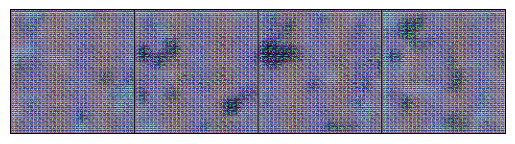

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
disc_losses, gen_losses = fit(
    generator=generator,
    discriminator=discriminator,
    epochs=16,
    dataloader=dataloader,
    disc_lr=1e-4,
    gen_lr=2e-4,
)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

/var/folders/ck/c65tgxxs72q4jb2lj3m952j40000gn/T/ipykernel_1670/436500613.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


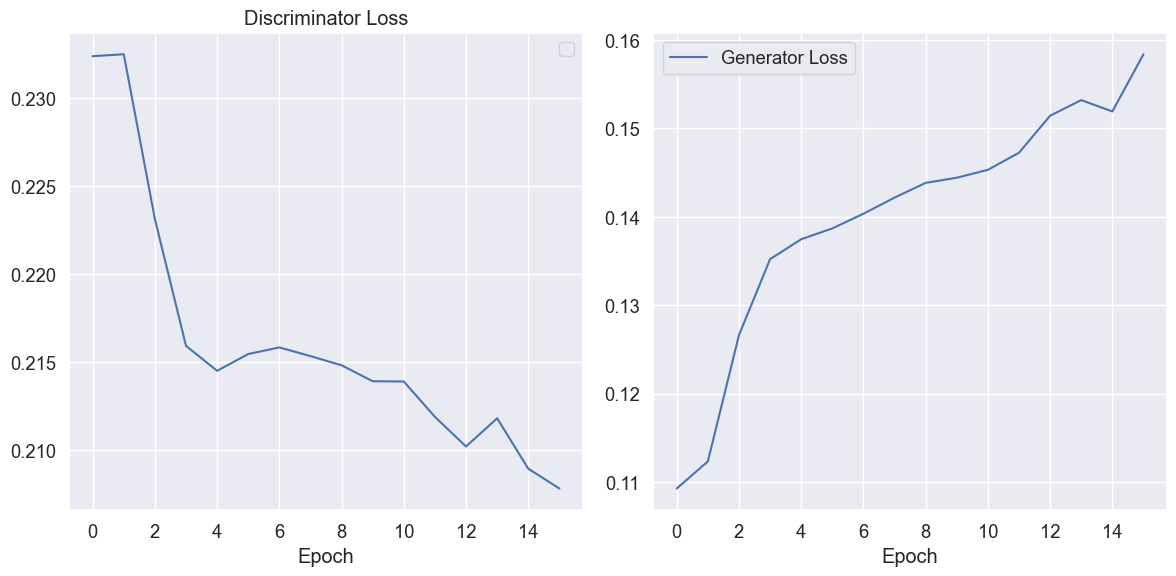

In [427]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot discriminator losses
axes[0].plot(disc_losses)
axes[0].set_title("Discriminator Loss")
axes[0].set_xlabel("Epoch")
axes[0].legend()

# Plot generator losses
axes[1].plot(gen_losses, label="Generator Loss")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [719]:
n_images = 4

fixed_latent = torch.randn(n_images, LATENT_DIM, device=device)
fake_images = generator(fixed_latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99572015..0.9222759].


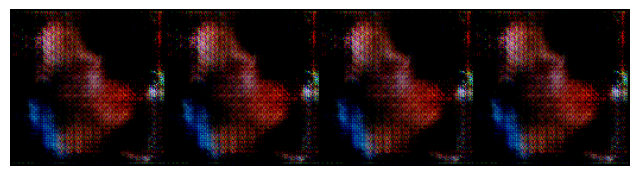

In [720]:
# TODO: show generated images
grid = make_grid(fake_images.detach().cpu(), nrow=n_images)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: